# 0. Reference
- [NYC-Taxi-Prediction](https://www.kaggle.com/finlay/nyc-taxi-prediction)
- [haversine](https://kayuse88.github.io/haversine/)

# 1. libray import, dataload

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import tensorflow as tf

import os
from pathlib import Path

In [ ]:
# Data load
train = pd.read_csv('../input/c/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('../input/c/nyc-taxi-trip-duration/test.zip')

In [ ]:
train.shape, test.shape

In [ ]:
train.head()
# test.head()
# train.info()
# test.info()

# 2. EDA

## haversine
- 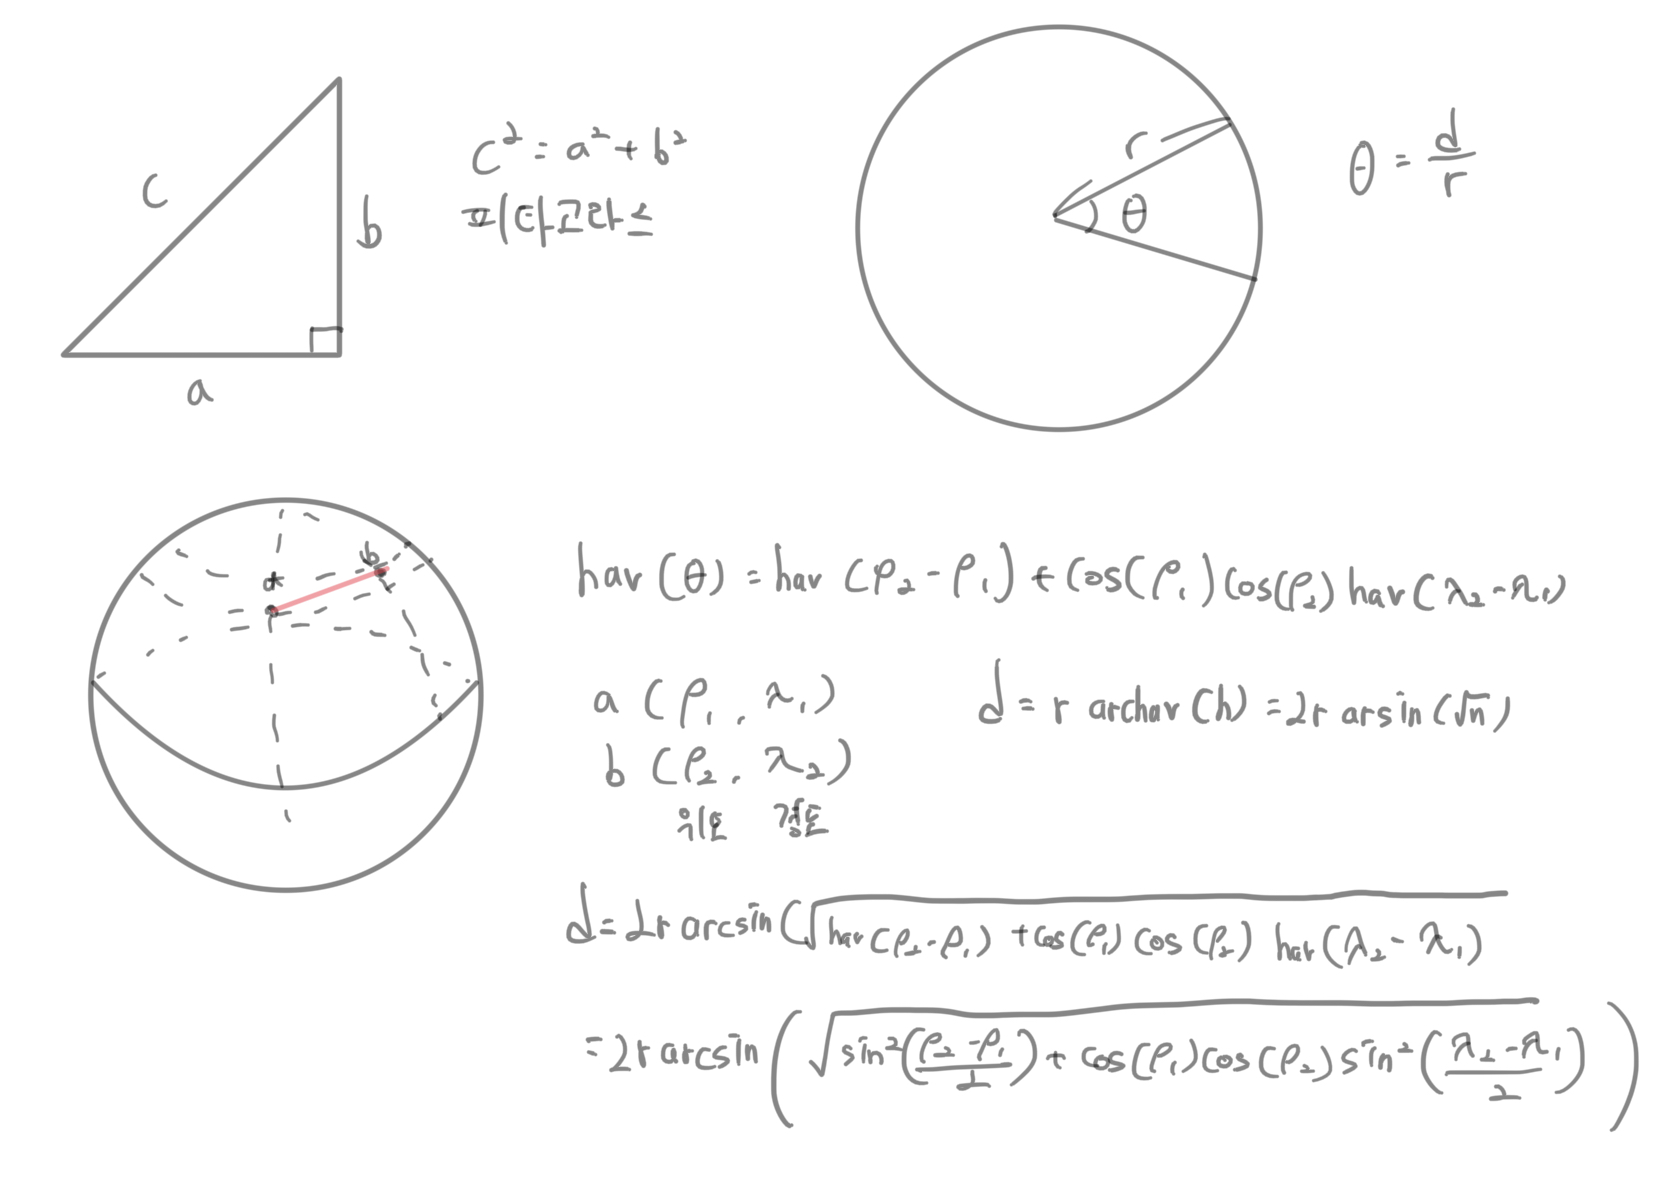


In [ ]:
from haversine import haversine

'''
from numpy import math 
def haversine(lat1, lon1, lat2, lon2):
    R = 6371800  # Earth radius in meters  
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))
    '''


train['distance'] = train.apply(lambda row: 
                                      haversine((row['pickup_latitude'], 
                                                row['pickup_longitude']), 
                                                (row['dropoff_latitude'], 
                                                row['dropoff_longitude']), unit='m'), axis=1)

test['distance']  = test.apply(lambda row: 
                                     haversine((row['pickup_latitude'], 
                                               row['pickup_longitude']), 
                                               (row['dropoff_latitude'], 
                                               row['dropoff_longitude']), unit='m'), axis=1)
# unit = 'm', 'km', 'mile'

In [ ]:
# outliuer 삭제
train.drop(train[train['trip_duration'] > 150000].index, axis = 0, inplace = True)

In [ ]:
train['trip_duration'] = np.log(train['trip_duration'].values) # scalering log

In [ ]:
train.head()

In [ ]:
# datetime 변환
from datetime import datetime
# train pickuptime
train['pickup_datetime'] = train['pickup_datetime'].astype('datetime64')

train["month"] = train.loc[:, "pickup_datetime"].dt.month
train["week"] = train.loc[:, "pickup_datetime"].dt.week
train['dayofweek'] = train.loc[:, 'pickup_datetime'].dt.dayofweek
train["hour"] = train.loc[:, "pickup_datetime"].dt.hour

# test pickuptime
test['pickup_datetime'] = test['pickup_datetime'].astype('datetime64')

test["month"] = test.loc[:, "pickup_datetime"].dt.month
test["week"] = test.loc[:, "pickup_datetime"].dt.week
test['dayofweek'] = test.loc[:, 'pickup_datetime'].dt.dayofweek
test["hour"] = test.loc[:, "pickup_datetime"].dt.hour



In [ ]:
# store_and_fwd_flag 변환
e = LabelEncoder()
train['store_and_fwd_flag'] = e.fit_transform(train['store_and_fwd_flag'])
test['store_and_fwd_flag'] = e.transform(test['store_and_fwd_flag'])



In [ ]:
Y_train = train["trip_duration"]
X_train = train[["vendor_id", "store_and_fwd_flag","passenger_count",
                    "pickup_longitude", "pickup_latitude", "distance", 
                    "dropoff_longitude","dropoff_latitude", 
                    "hour", "week", "dayofweek", "month" ]]

In [ ]:
train.head()

# 4. model 실행

## Ridge
- 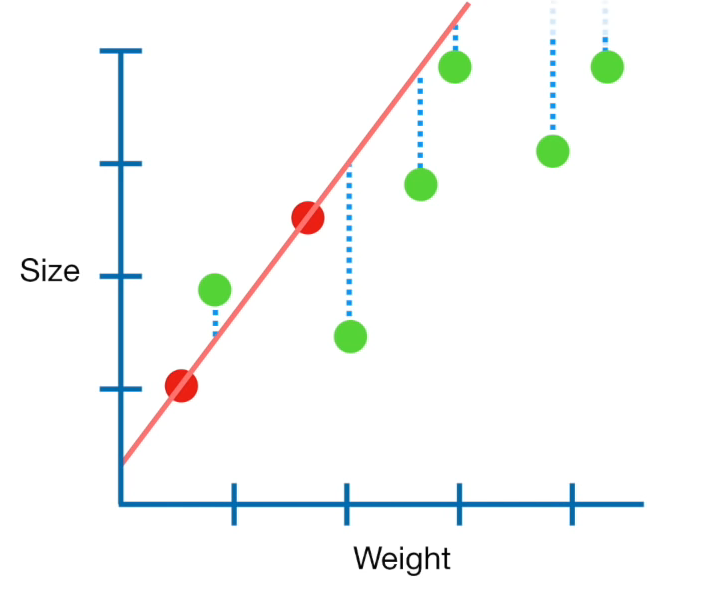
</p>
- 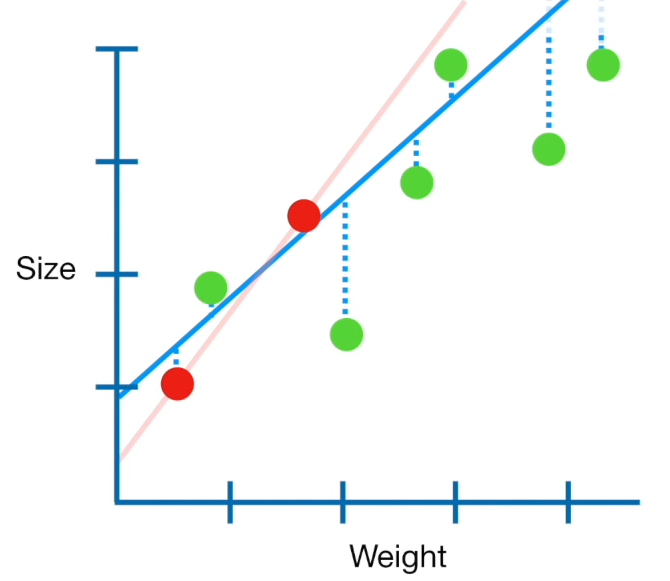

## LGBRegressor
- Gradiant Bosting
- 깊이를 작게하고 나무의 갯수를 늘리는 전략을 많이 취한다.
- 학습률 조정

In [ ]:
from sklearn.model_selection import cross_val_score # 교차검증
from sklearn.linear_model import Ridge
m = Ridge()

cross_val_score(m, X_train, Y_train, cv=5) #5겹 교차검증

In [ ]:
%%time
from sklearn.linear_model import Ridge
m = Ridge()
m.fit(X_train, Y_train)

X_test = test[["vendor_id", "store_and_fwd_flag","passenger_count","pickup_longitude", "pickup_latitude", "distance","dropoff_longitude","dropoff_latitude", "hour", "week", "dayofweek", "month"]]
prediction = m.predict(X_test)
prediction

In [ ]:
from lightgbm import LGBMRegressor
m = LGBMRegressor(n_estimators=500) # 500개 Tree갯수
m.fit(X_train, Y_train)

X_test = test[["vendor_id", "store_and_fwd_flag","passenger_count","pickup_longitude", "pickup_latitude", "distance","dropoff_longitude","dropoff_latitude", "hour", "week", "dayofweek", "month"]]
prediction = m.predict(X_test)
prediction

In [ ]:
submit = pd.read_csv('../input/c/nyc-taxi-trip-duration/sample_submission.zip', compression='zip')
submit.head()
submit['trip_duration'] = np.exp(prediction)
submit.to_csv('sample_submission.zip.csv', index=False)